# Description:

This notebook contains several experiments with bokeh and hexagonal matrices in order to produce a suitable U-matrix and test the interactive components we want to include in the visualization.

In [4]:
from bokeh.colors import RGB
from bokeh.core.properties import AngleSpec
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, LinearColorMapper, AdaptiveTicker
from bokeh.plotting import figure, output_file
from bokeh.util.hex import cartesian_to_axial
from matplotlib.pyplot import get_cmap
from matplotlib.colors import rgb2hex

import os
from collections import defaultdict
import sompy
import numpy as np
import pandas as pd
from src.visualization.embedding_space import embedding_vectors, read_data
from src.cluster.som_clustering import UMatrix, main
from src import PROJECT_ROOT

# display bokeh plot in notebook
output_notebook()

Loading BokehJS ...

In [5]:
data_file = os.path.join(PROJECT_ROOT, "data","processed", "newsapi_docs.csv")
model_dir = os.path.join(PROJECT_ROOT, "models", "saved_models")
fig_dir = os.path.join(PROJECT_ROOT, "models", "figures", "som")
model_path = os.path.join(PROJECT_ROOT, "models/saved_models/doc2vecdbowd100n5mc2t4.model")

In [6]:
model_tag = os.path.splitext(os.path.basename(model_path))[0]

# Reading data into memory
_, train_docs, test_docs = read_data(data_file)
train_labels = train_docs['category']

# Obtain the vectorized corpus
vect_train_corpus, _ = embedding_vectors(
    model_path, train_docs['prep_text'], test_docs['prep_text'])

# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

som = sompy.SOMFactory().build(
    vect_train_corpus,
    mapsize=(50, 50),
    initialization='pca',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)

Read data has a size of 5283Kb
Formatting data...
88052 documents from train set out of 110065 documents
loading Doc2Vec object from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model
loading vocabulary recursively from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model.vocabulary.* with mmap=None
loading trainables recursively from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model.trainables.* with mmap=None
loading wv recursively from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model.wv.* with mmap=None
loading docvecs recursively from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model.docvecs.* with mmap=None
loaded /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model
 Training...
 pca_linear_initialization took: 0.311000 seconds
 Rough training...
 radius_ini: 7.000000 , radi

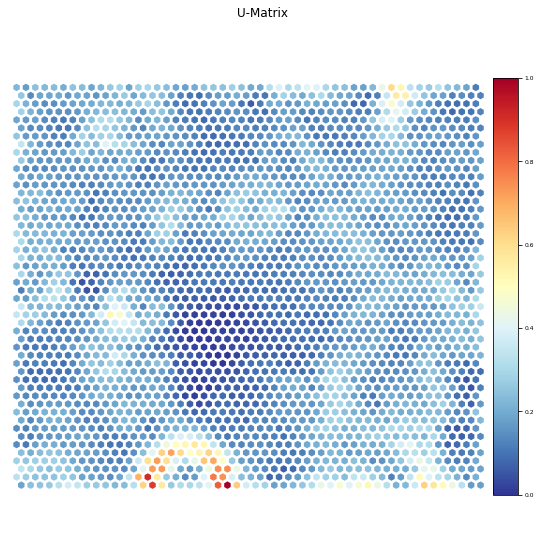

In [7]:
# Plot U-matrix using the UMatrix class
_, umat = UMatrix(
        width=12,
        height=12,
        text_size=6,
        title="U-Matrix",
        som=som,
        distance2=1,
        row_normalized=False,
        show_data=False,
        contoor=False
    ).show()

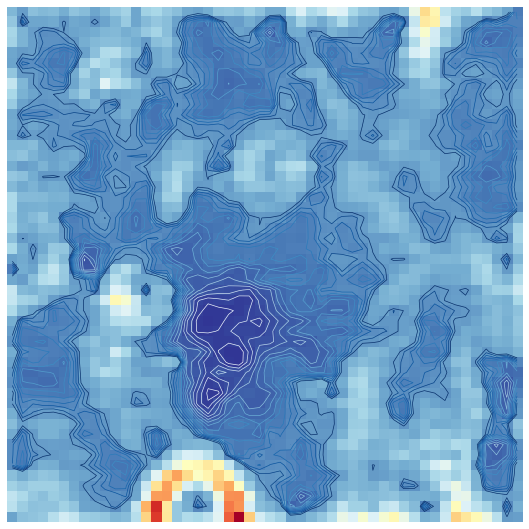

In [8]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    som, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

## U-matrix using Bokeh
### Challenges:

- Given a grid of size (x, y), place x\*y hexagons to form a hexagonal grid with odd-row offset:
    - locate the centers of each hexagon
    - figure out the right hexagon size
    - figure out the right offset value
    - ensure the grid is preserved when the image is changed (zoom, image size, screen size, etc)

Reference https://www.redblobgames.com/grids/hexagons/:
-  In the pointy orientation, a hexagon has width w = sqrt(3) * size and height h = 2 * size. The sqrt(3) comes from sin(60°).

In [9]:
# Builds the U-Matrix - each cell is the average distance of a given unit to its neighbors, where neighbors are units with distance less than self.distance2
# Reference: https://github.com/JustGlowing/minisom/blob/master/examples/HexagonalTopology.ipynb
# The mapsize of the codebook (tuple)
msz = som.codebook.mapsize
# Same output as get_euclidean_coordinates
xx, yy = np.meshgrid(np.arange(msz[0]), np.arange(msz[1]))
xx, yy = xx.astype(float), yy.astype(float)
if som.codebook.lattice == 'hexa':  # apply odd-r hexagonal grid offset
    xx[::-2] -= 0.5
xx, yy = xx.T, yy.T
# Gets the BMU id for each data sample
proj = som.project_data(som.data_raw)
# # Gets the x and y coordinates of each sample's BMU
# xy = np.unravel_index(proj, msz)
# coord = np.vstack((xx[xy], yy[xy])).T

In [10]:
# https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-iii-a-complete-dashboard-dc6a86aa6e23

In [11]:
# Plot Data
hex_values = defaultdict(list)
categories = train_labels.unique()

# Iterate over grid position to compute hex centers and hex color
uid = 0
for i in range(msz[0]):
    for j in range(msz[1]):
        wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
        unit_labels = train_labels.values[proj==uid]
        freq = np.sum(proj==uid)
        hex_values['hex_centre_row'].append(wy)
        hex_values['hex_centre_col'].append(xx[i, j])
        hex_values['hex_dist'].append(umat[i, j])
        hex_values['hex_freq'].append(freq)
        for k in categories:
            if freq == 0:
                rfreq_categ = 0
            else:
                rfreq_categ = int((np.sum(unit_labels==k) / freq) * 100)
            hex_values[f'hex_{k}'].append(rfreq_categ)
        uid += 1

# # Assign observations to each hex (the one corresponding to its BMU)
# weight_x, weight_y = coord[:, 0], coord[:, 1] * 2 / np.sqrt(3) * 3 / 4
# n_rows = weight_x.shape[0]
# sample_size = 0.1
# sample_ix = np.random.randint(0, n_rows, int(n_rows*sample_size))

In [12]:
# initialise figure/plot
fig = figure(title="SOM: Hexagonal Topology",
             plot_height=700, plot_width=700,
             match_aspect=True, toolbar_location='right')

# define markers
markers = ['circle', 'diamond', 'cross', 'inverted_triangle', 'triangle', 'square', 'asterisk']

# define color_mapper
colormap = get_cmap('RdYlBu_r')
pallete_colors = [rgb2hex(colormap(i)) for i in range(colormap.N)]
color_mapper = LinearColorMapper(palette=pallete_colors)

# create data stream for plotting
scaling_factor = 1 / np.sqrt(3)  # I don't understand this. It works though
q, r = cartesian_to_axial(np.array(hex_values['hex_centre_col']), np.array(hex_values['hex_centre_row']), 
                          size=scaling_factor, orientation='pointytop')
data = {k: v for k, v in hex_values.items() if k not in ['hex_centre_row', 'hex_centre_col']}
data['q'], data['r'] = q, r
source_hex = ColumnDataSource(
    data = data
)

# wy, wx = weight_y / scaling_factor, weight_x / scaling_factor
# source_pages = ColumnDataSource(
#     data=dict(
#         wx=wy[sample_ix],
#         wy=wx[sample_ix],
#         species=train_labels[sample_ix]
#     )
# )

# add shapes to plot
fig.hex_tile(q='q', r='r', source=source_hex,
             line_color='gray',
             fill_color={'field': 'hex_dist', 'transform': color_mapper})

# fig.scatter(x='wy', y='wx', source=source_pages, 
#              legend_field='species',
#              size=10,
#              alpha=0.2,
#              marker=factor_mark(field_name='species', markers=markers, factors=categories),
#              color=factor_cmap(field_name='species', palette='Category10_7', factors=categories))

# add colorbar
color_bar = ColorBar(color_mapper=color_mapper, ticker=AdaptiveTicker(), 
                     label_standoff=10, border_line_color=None, 
                     height=500, location=(0, 75))
fig.add_layout(color_bar, 'right')

# add hover-over tooltip
fig.add_tools(HoverTool(
    tooltips=[
#         ("label", '@species'),
#         ("distance", '@hex_dist'),
        ("frequency", '@hex_freq'),
        ("health", '@hex_health%'),
        ("general", '@hex_general%'),
        ("entretainment", '@hex_entertainment%'),
        ("sports", '@hex_sports%'),
        ("tech", '@hex_technology%'),
        ("business", '@hex_business%'),
        ("science", '@hex_science%')
    ],
    mode="mouse",
    point_policy="follow_mouse"
))

# figure options
fig.title.align = "center"
fig.title.text_font_size = "25px"
fig.grid.visible = False
fig.axis.visible = False

show(fig)